In [41]:
!pip install -q git+https://github.com/tensorflow/examples.git


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow.keras.layers import * 
from tensorflow.keras import Model, Input  
from tensorflow.keras.models import * 
from tensorflow.keras.callbacks import *
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split 
from sklearn.metrics import f1_score
import random 
import os 
import time 
from tqdm import tqdm 
import keras.backend as K
import datetime
from tensorflow_examples.models.pix2pix import pix2pix
from efficientnet.keras import EfficientNetB0

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.head()

,month,file_nm
0,1978-11,197811.npy
1,1978-12,197812.npy
2,1979-01,197901.npy
3,1979-02,197902.npy
4,1979-03,197903.npy


In [4]:
filenames = train['file_nm'].values

In [5]:
tot = np.stack([np.load('train/train/' + f) for f in filenames])

In [6]:
print("tot.shape = {}".format(tot.shape))

tot.shape = (482, 448, 304, 5)


In [7]:
class HParams(object):
    def __init__(self):
        ## Pole Patch
        self.pole_large_idx  = np.arange(0, 105, 1)
        self.pole_medium_idx = np.arange(106, 349, 1)
        self.pole_small_idx  = np.arange(350, 482, 1)
        
        ## Train & test split
        self.num_test = 48
        self.val_size = 0.25 ## not 0.2
        
        ## Dataset Pipeline
        self.w_inp = 4
        self.w_tar = 2
        self.w_sft = 1
        self.w_std = 12 ## every year
        self.w_dr  = True
        
        self.buffer_sz = 1_000
        self.auto = tf.data.experimental.AUTOTUNE
        self.global_batch_sz = 8
        
        ## Modeling
        self.backbone = tf.keras.applications.MobileNetV2
        self.backbone2 = EfficientNetB0
        
        self.image_sz         = [448, 304]
        self.resized_image_sz = [int(np.ceil(i / 2 **5) * 2 ** 5) for i in self.image_sz] ## [448, 320]
        
        ## Fit
        self.epoch = 50
        
        
HPARAMS = HParams()


In [8]:
## The area to which zero padding is added is regarded as the ground surface.
padded_tot = np.zeros((tot.shape[0], *HPARAMS.resized_image_sz, tot.shape[3]), dtype = np.uint8)
padded_tot[..., 3] = 1

padded_tot[:tot.shape[0], :tot.shape[1], :tot.shape[2], :tot.shape[3]] = tot

print(f"padded_tot.shape: {padded_tot.shape}")


padded_tot.shape: (482, 448, 320, 5)


In [9]:
padded_tot[..., 3] += padded_tot[..., 2] ## concat two masks

tr_npy = padded_tot[:-HPARAMS.num_test, ..., [0, 3]]
ts_npy = padded_tot[-HPARAMS.num_test:, ..., [0, 3]]

print(f"tr_npy.shape: {tr_npy.shape}")
print(f"ts_npy.shape: {ts_npy.shape}")


tr_npy.shape: (434, 448, 320, 2)
ts_npy.shape: (48, 448, 320, 2)


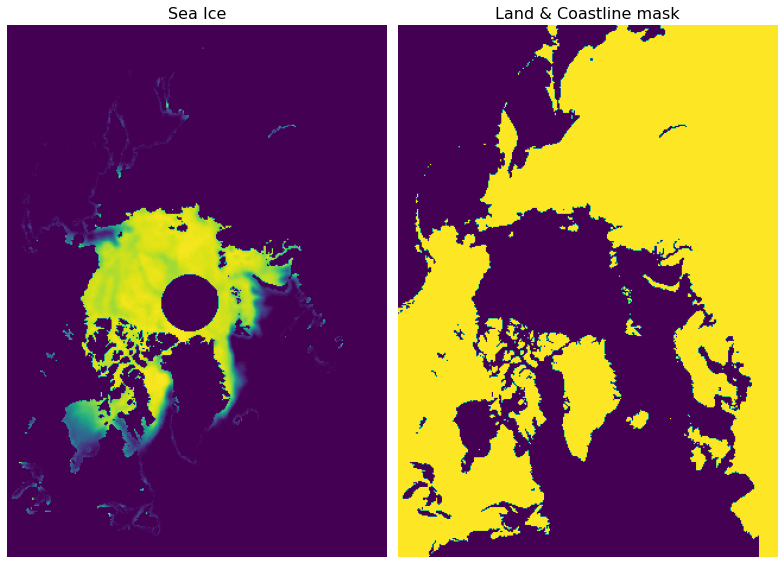

In [10]:
plt.figure(figsize = (11, 8), facecolor = "white")
plt.subplot(1, 2, 1)
plt.title("Sea Ice", fontsize = 16)
plt.imshow(tr_npy[0, ..., 0])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Land & Coastline mask", fontsize = 16)
plt.imshow(tr_npy[0, ..., 1])
plt.axis("off")

plt.tight_layout()
plt.show()


In [11]:
split_len = int(tr_npy.shape[0] * HPARAMS.val_size)
vl_npy = tr_npy[-split_len:]
tr_npy = tr_npy[:-split_len]

print(f"tr_npy.shape: {tr_npy.shape}")
print(f"vl_npy.shape: {vl_npy.shape}")
print(f"ts_npy.shape: {ts_npy.shape}")


tr_npy.shape: (326, 448, 320, 2)
vl_npy.shape: (108, 448, 320, 2)
ts_npy.shape: (48, 448, 320, 2)


In [12]:
@tf.function
def flat_fn_tr(x):
    return x.batch(HPARAMS.w_inp + HPARAMS.w_tar)


@tf.function
def flat_fn_ts(x):
    return x.batch(HPARAMS.w_inp)


@tf.function
def split_mask(x):
    return tf.split(x, [1, 1], axis = -1) ## keep dims


@tf.function
def rescaling(images, masks):
    return (tf.cast(images, dtype = tf.dtypes.float32) / 250., ## must divide 250, not 255
            tf.cast(masks[:, 0], tf.dtypes.float32)) ## no scaling


@tf.function
def split_window(images, masks):
    inp, tar = tf.split(images, [HPARAMS.w_inp, HPARAMS.w_tar], axis = 1)
    return (inp, masks), tar


In [13]:
## Numpy to tensor
tr_tensor = tf.constant(tr_npy)
vl_tensor = tf.constant(vl_npy)
ts_tensor = tf.constant(ts_npy)

## Make dataset pipeline
tr_ds = tf.data.Dataset.from_tensor_slices(tr_tensor
                    ).window(HPARAMS.w_inp + HPARAMS.w_tar, HPARAMS.w_sft, HPARAMS.w_std, HPARAMS.w_dr
                    ).flat_map(flat_fn_tr
                    ).shuffle(HPARAMS.buffer_sz
                    ).batch(HPARAMS.global_batch_sz
                    ).map(split_mask, num_parallel_calls = HPARAMS.auto
                    ).map(rescaling, num_parallel_calls = HPARAMS.auto
                    # ).map(slice_images, num_parallel_calls = HPARAMS.auto).unbatch(
                    ).map(split_window, num_parallel_calls = HPARAMS.auto
                    ).prefetch(HPARAMS.auto)

vl_ds = tf.data.Dataset.from_tensor_slices(vl_tensor
                    ).window(HPARAMS.w_inp + HPARAMS.w_tar, HPARAMS.w_sft, HPARAMS.w_std, HPARAMS.w_dr
                    ).flat_map(flat_fn_tr
                    # ).shuffle(HPARMAS.buffer_sz
                    ).batch(HPARAMS.global_batch_sz
                    ).map(split_mask, num_parallel_calls = HPARAMS.auto
                    ).map(rescaling, num_parallel_calls = HPARAMS.auto
                    # ).map(slice_images, num_parallel_calls = HPARAMS.auto).unbatch(
                    ).map(split_window, num_parallel_calls = HPARAMS.auto
                    ).prefetch(HPARAMS.auto)

ts_ds = tf.data.Dataset.from_tensor_slices(ts_tensor
                    ).window(HPARAMS.w_inp, HPARAMS.w_sft, HPARAMS.w_std, HPARAMS.w_dr
                    ).flat_map(flat_fn_ts
                    # ).shuffle(HPARMAS.buffer_sz
                    ).batch(HPARAMS.global_batch_sz
                    ).map(split_mask, num_parallel_calls = HPARAMS.auto
                    ).map(rescaling, num_parallel_calls = HPARAMS.auto
                    # ).map(slice_images, num_parallel_calls = HPARAMS.auto).unbatch(
                    # ).map(split_window, num_parallel_calls = HPARAMS.auto
                    ).prefetch(HPARAMS.auto)

## Print the shapes
print(f"tr_ds.element_spec: {tr_ds.element_spec}")
print(f"vl_ds.element_spec: {vl_ds.element_spec}")
print(f"ts_ds.element_spec: {ts_ds.element_spec}")


tr_ds.element_spec: ((TensorSpec(shape=(None, 4, 448, 320, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 448, 320, 1), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 2, 448, 320, 1), dtype=tf.float32, name=None))
vl_ds.element_spec: ((TensorSpec(shape=(None, 4, 448, 320, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 448, 320, 1), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 2, 448, 320, 1), dtype=tf.float32, name=None))
ts_ds.element_spec: (TensorSpec(shape=(None, None, 448, 320, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 448, 320, 1), dtype=tf.float32, name=None))


In [14]:
len(list(tr_ds.unbatch().as_numpy_iterator()))


266

In [15]:
len(list(vl_ds.unbatch().as_numpy_iterator()))


48

In [16]:
len(list(ts_ds.unbatch().as_numpy_iterator()))


12

In [17]:
for element in tr_ds.take(1):
    (foo, bar), qux = element
    print(foo.shape, bar.shape, qux.shape)


(8, 4, 448, 320, 1) (8, 448, 320, 1) (8, 2, 448, 320, 1)


## Define Model

In [18]:
def Backbone():
    m = HPARAMS.backbone2(input_shape = (*HPARAMS.resized_image_sz, 3), 
                         include_top = False,
                         weights = None)
    
    '''
    layer_names = ["block_1_expand_relu",  ## 224 x 160 x  96
                   "block_3_expand_relu",  ## 112 x  80 x 144
                   "block_6_expand_relu",  ##  56 x  40 x 192
                   "block_13_expand_relu", ##  28 x  20 x 576
                   "block_16_project"]     ##  14 x  10 x 320  
    ''' 
    
    layer_names = ["block1a_activation", 
                   "block2a_activation", 
                   "block3a_activation", 
                   "block4a_activation",  
                   "block6b_project_conv"] 
    

    return tf.keras.Model(inputs = m.input,
                          outputs = [m.get_layer(name).output for name in layer_names])
            

class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.backbone = Backbone()
        
        
    def call(self, x, return_skips = True):
        if x.shape[-1] == 1:
            ## Same as x = tf.image.grayscale_to_rgb(x)
            x = tf.tile(x, [1, 1, 1, 3])

        xs = self.backbone(x)
        if return_skips:
            return xs[-1], xs[:-1]
        else:
            return xs[-1]


class Decoder(tf.keras.Model):
    def __init__(self, ):
        super(Decoder, self).__init__()
        self.ups = [pix2pix.upsample(256, 4, apply_dropout = True),
                    pix2pix.upsample(128, 4, apply_dropout = True),
                    pix2pix.upsample(64, 4),
                    pix2pix.upsample(32, 4)]
        
        self.convT = tf.keras.layers.Conv2DTranspose(32, 3, strides = 2, padding = "same")
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv2d = tf.keras.layers.Conv2D(1, 1, activation = "sigmoid")
        
        
    def call(self, x, skips):
        for up in self.ups:
            x = up(x)
            x = tf.keras.layers.Concatenate()([x, skips.pop()])            
            
        x = self.convT(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2d(x)
        
        return x
    
    
class UnetModel(tf.keras.Model):
    def __init__(self, name):
        super(UnetModel, self).__init__(name = name)
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.convlstm = tf.keras.layers.ConvLSTM2D(256, 3, padding = "same", 
                                                   return_state = True, recurrent_dropout = 0.4)
        
        self.out_steps = HPARAMS.w_tar
        
    
    def warmup(self, x, skips):
        x, *state = self.convlstm(x)
        prediction = self.decoder(x, skips)
        return prediction, state
    
    
    def call(self, inputs, training = None):
        ## Split inputs as x and masks, and reshape dims of masks as out_steps.
        x, masks = inputs
        masks = tf.tile(tf.expand_dims(masks, axis = 1), [1, self.out_steps, 1, 1, 1])

        predictions = []
        
        ## Create skip using the most recent timestamp
        _, skips = self.encoder(x[:, -1]) 
        
        ## (None, 24, 7, 5, 320)
        x = tf.stack([self.encoder(sub_x, return_skips = False) 
                      for sub_x in tf.unstack(x, axis = 1)], axis = 1) 

        ## Warmup the convlstm
        prediction, state = self.warmup(x, skips)
        predictions.append(prediction)
        
        ## Calculate each timestamp images (out_steps - 1 times)
        for _ in range(1, self.out_steps):
            x, skips = self.encoder(prediction)
            x, *state = self.convlstm(tf.expand_dims(x, axis = 1), 
                                      initial_state = state, 
                                      training = training)
            
            prediction = self.decoder(x, skips)
            predictions.append(prediction)
        
        return tf.stack(predictions, axis = 1) * (1. - masks)


In [19]:
@tf.function
def mae_score(y_true, y_pred):
    return tf.math.reduce_mean(tf.math.abs(y_true - y_pred))


@tf.function
def f1_score(y_true, y_pred, lower_bound = 0.05, upper_bound = 0.5, threshold = 0.5, epsilon = 1e-8):
    ## All values other than the aperture (0.05, 0.5) are clipped 
    ## to 0 to force the position to be true negative.
    y_true = tf.where(y_true > upper_bound, 0., y_true)
    y_true = tf.where(y_true < lower_bound, 0., y_true)
    y_pred = tf.where(y_pred > upper_bound, 0., y_pred)
    y_pred = tf.where(y_pred < lower_bound, 0., y_pred)

    ## Clip by threshold
    y_true = tf.where(y_true < 0.15, 0., 1.)
    y_pred = tf.where(y_pred < 0.15, 0., 1.)

    tp = tf.math.reduce_sum(tf.where(y_true * y_pred == 1., 1., 0.)) ## true positive
    precision = tp / (tf.math.reduce_sum(y_true) + epsilon)
    recall = tp / (tf.math.reduce_sum(y_pred) + epsilon)
    
    return 2 * precision * recall / (precision + recall + epsilon)


@tf.function
def mae_over_f1(y_true, y_pred, epsilon = 1e-8):
    return tf.math.divide_no_nan(mae_score(y_true, y_pred), 
                                 f1_score(y_true, y_pred) + epsilon)


In [20]:
def get_callbacks(model_name):    
    ## Checkpoint callback.
    ckpt_path = f"ckpt/{model_name}/" + "cp-{epoch:03d}-{val_loss:.4f}.ckpt"
    os.makedirs(os.path.dirname(ckpt_path), exist_ok = True)
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, verbose = 0, monitor = "val_loss", save_weights_only = True, save_best_only = True)
    
    return [cp_callback]


In [21]:
model_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

model = UnetModel(name = model_name)
model.compile(optimizer = "adam",
              loss = mae_over_f1,
              metrics = [mae_score, f1_score])


In [22]:
_ = model.fit(tr_ds, 
              validation_data = vl_ds,
              epochs = HPARAMS.epoch,
              verbose = 1,
              callbacks = get_callbacks(model.name)) 


Epoch 1/50
34/34 [==============================] - 96s 1s/step - loss: 2.3181 - mae_score: 0.1044 - f1_score: 0.1187 - val_loss: 2.0588 - val_mae_score: 0.1572 - val_f1_score: 0.0765
Epoch 2/50
34/34 [==============================] - 26s 736ms/step - loss: 0.1257 - mae_score: 0.0373 - f1_score: 0.2985 - val_loss: 0.7254 - val_mae_score: 0.0851 - val_f1_score: 0.1177
Epoch 3/50
34/34 [==============================] - 36s 954ms/step - loss: 0.1013 - mae_score: 0.0314 - f1_score: 0.3115 - val_loss: 0.1514 - val_mae_score: 0.0433 - val_f1_score: 0.2879
Epoch 4/50
34/34 [==============================] - 27s 742ms/step - loss: 0.0855 - mae_score: 0.0275 - f1_score: 0.3241 - val_loss: 0.0817 - val_mae_score: 0.0298 - val_f1_score: 0.3660
Epoch 5/50
34/34 [==============================] - 29s 832ms/step - loss: 0.0737 - mae_score: 0.0251 - f1_score: 0.3423 - val_loss: 0.0747 - val_mae_score: 0.0260 - val_f1_score: 0.3508
Epoch 6/50
34/34 [==============================] - 26s 728ms/step -

Epoch 45/50
34/34 [==============================] - 25s 720ms/step - loss: 0.0215 - mae_score: 0.0109 - f1_score: 0.5093 - val_loss: 0.0527 - val_mae_score: 0.0176 - val_f1_score: 0.3364
Epoch 46/50
34/34 [==============================] - 26s 720ms/step - loss: 0.0218 - mae_score: 0.0111 - f1_score: 0.5089 - val_loss: 0.0491 - val_mae_score: 0.0168 - val_f1_score: 0.3449
Epoch 47/50
34/34 [==============================] - 25s 718ms/step - loss: 0.0205 - mae_score: 0.0107 - f1_score: 0.5232 - val_loss: 0.0496 - val_mae_score: 0.0172 - val_f1_score: 0.3494
Epoch 48/50
34/34 [==============================] - 25s 718ms/step - loss: 0.0206 - mae_score: 0.0107 - f1_score: 0.5174 - val_loss: 0.0498 - val_mae_score: 0.0173 - val_f1_score: 0.3492
Epoch 49/50
34/34 [==============================] - 26s 765ms/step - loss: 0.0205 - mae_score: 0.0106 - f1_score: 0.5200 - val_loss: 0.0522 - val_mae_score: 0.0174 - val_f1_score: 0.3347
Epoch 50/50
34/34 [==============================] - 31s 754

## Prediction

In [23]:
def load_latest_checkpoint(ckpt_folder):
    latest = tf.train.latest_checkpoint(ckpt_folder)
    print(f"Load latest checkpoints: {latest}...")
    
    model = UnetModel(name = f"{ckpt_folder.split('/')[-1]}-latest")
    ckpt = tf.train.Checkpoint(model)
    ckpt.restore(latest).expect_partial()
    
    print(f"Restored model: {model.name}")
    
    return model


In [24]:
ckpt_folder = f"ckpt/{model.name}"
latest_model = load_latest_checkpoint(ckpt_folder)


Load latest checkpoints: ckpt/20210306-062352/cp-033-0.0481.ckpt...
Restored model: 20210306-062352-latest


In [25]:
result = []
for element in ts_ds:
    result.append(latest_model.predict(element))
result = np.concatenate(result, axis = 0)
result = np.reshape(result, (result.shape[0] * result.shape[1], *result.shape[2:]))

print(f"result.shape: {result.shape}")


result.shape: (24, 448, 320, 1)


In [26]:
rebuilded_image = result[:, :HPARAMS.image_sz[0], :HPARAMS.image_sz[1]]
rebuilded_image = np.clip(rebuilded_image, 0, 1) * 250
rebuilded_image = rebuilded_image.astype(np.uint8)

print(f"rebuilded_image.shape: {rebuilded_image.shape},", \
      f"rebuilded_image.dtype: {rebuilded_image.dtype}")


rebuilded_image.shape: (24, 448, 304, 1), rebuilded_image.dtype: uint8


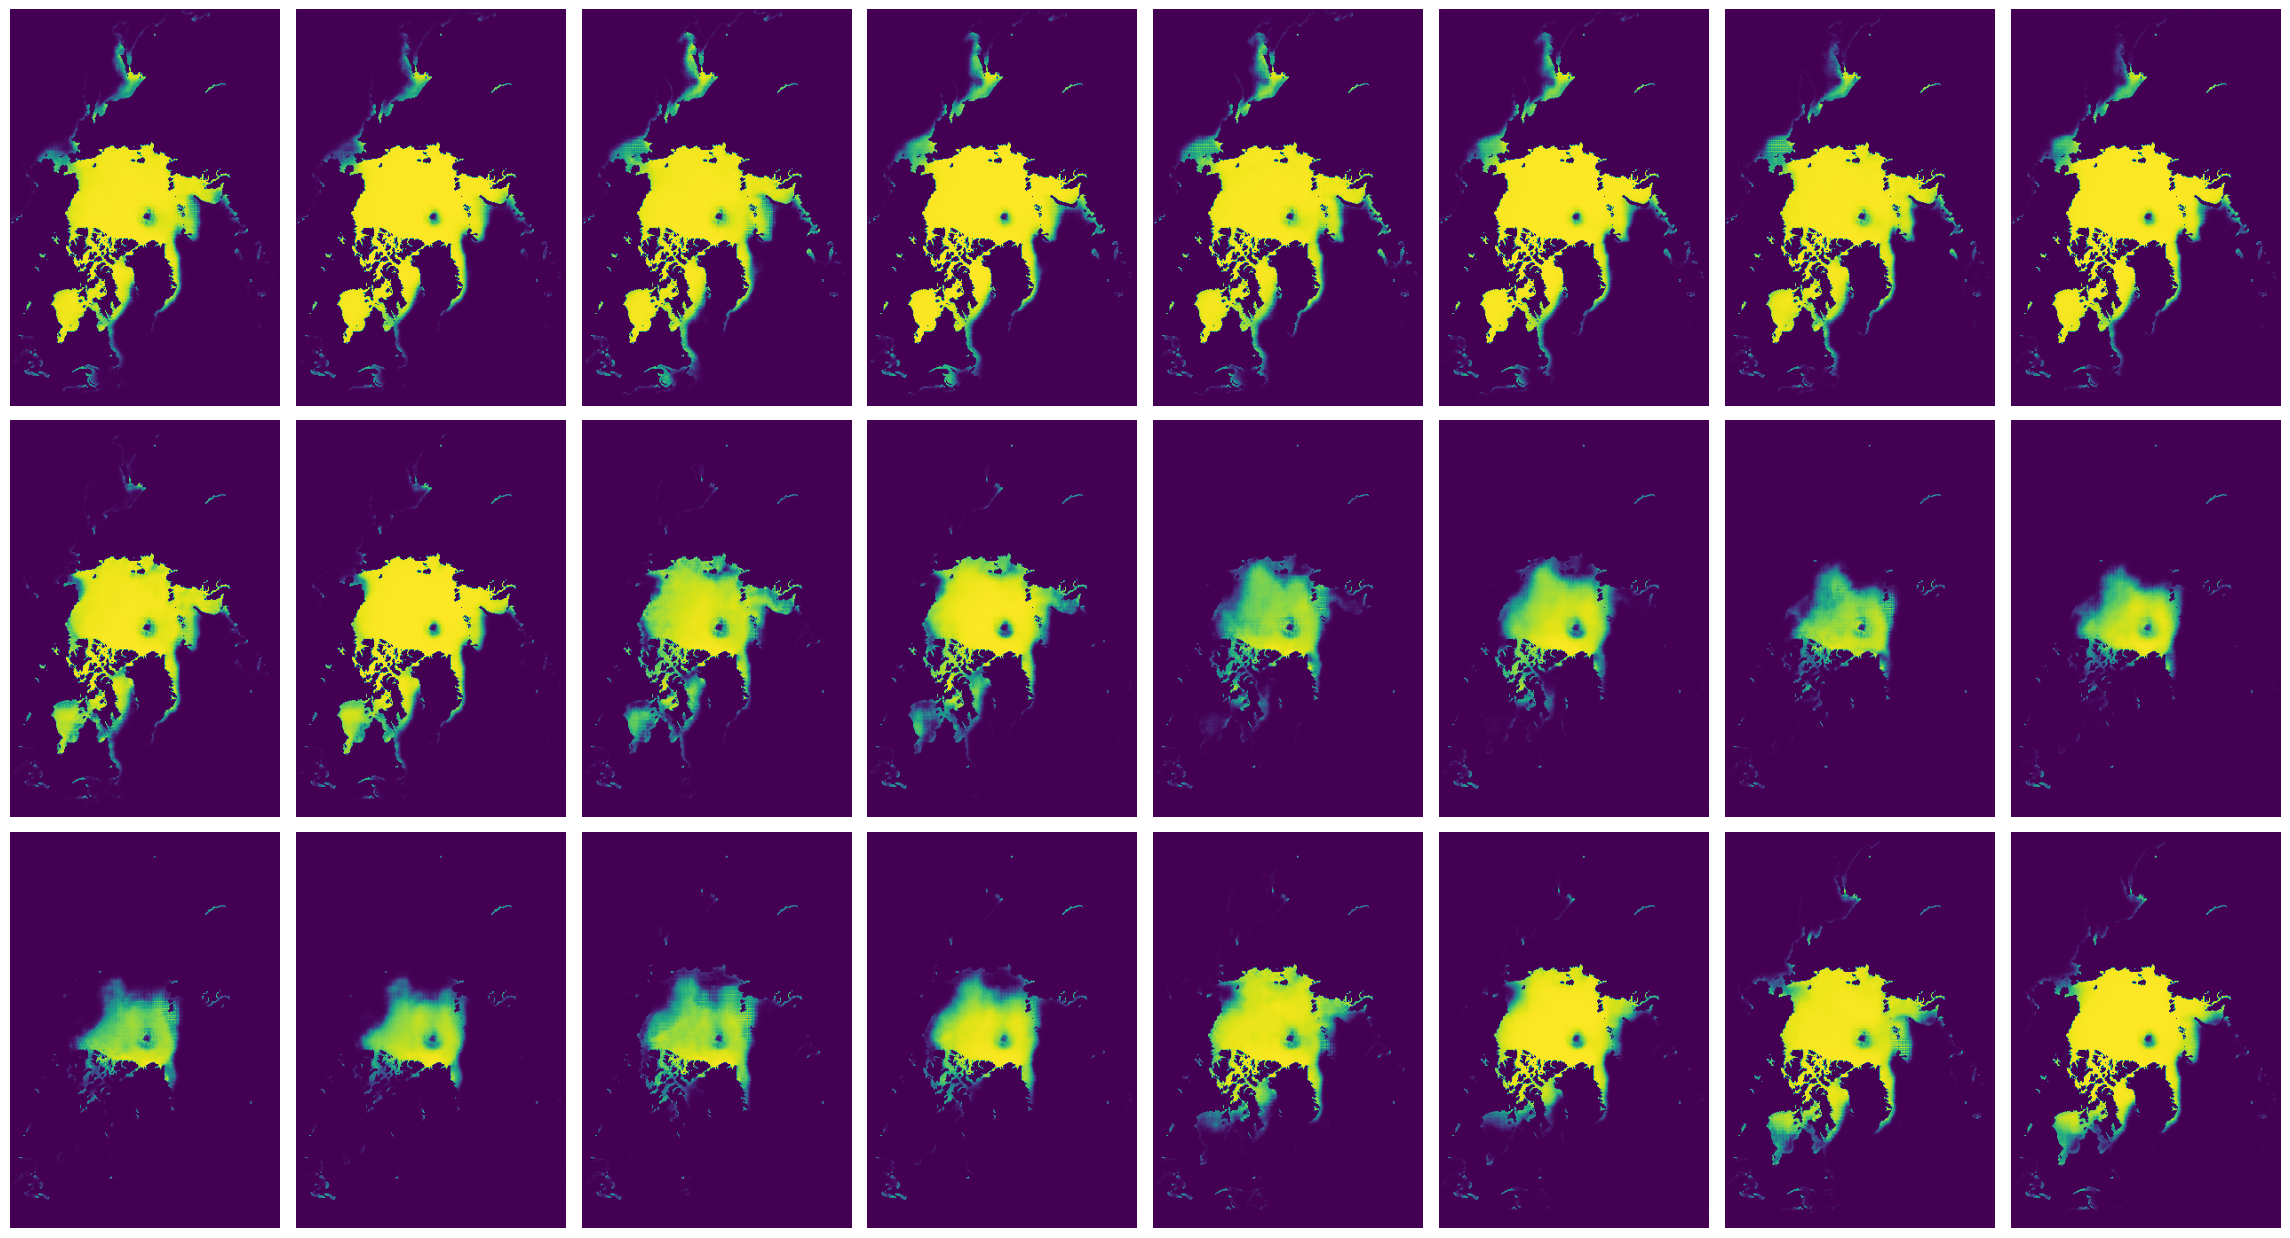

In [27]:
plt.figure(figsize = (24, 13), facecolor = "white", dpi = 96)
for i, img in enumerate(rebuilded_image):
    plt.subplot(3, 8, i + 1)
    plt.imshow(img[..., 0])
    plt.axis("off")

plt.tight_layout()
plt.show()


In [28]:
submission = pd.read_csv('sample_submission.csv', index_col = 0)
submission.shape


(24, 136192)

In [29]:
submission.head().T

month,2019-01,2019-02,2019-03,2019-04,2019-05
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
136187,0,0,0,0,0
136188,0,0,0,0,0
136189,0,0,0,0,0
136190,0,0,0,0,0


In [30]:
rebuilded_image.shape

(24, 448, 304, 1)

In [31]:
submission = pd.read_csv('sample_submission.csv')

In [32]:
submission.iloc[:,1:] = rebuilded_image.reshape((24,448*304))

In [33]:
submission.to_csv('efficientnetb0_pix2pix.csv',index=False)

## Average dataframes 

In [34]:
df1 = pd.read_csv('mobilenet_pix2pix.csv') 
df2 = pd.read_csv('efficientnetb0_pix2pix.csv')

In [35]:
submission = pd.read_csv('sample_submission.csv') 

submission.iloc[:,1:] = (df1.iloc[:,1:] + df2.iloc[:,1:]) / 2.0 

submission.head() 

,month,0,1,2,3,4,5,6,7,8,...,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191
0,2019-01,12.0,4.5,2.5,1.5,1.0,1.5,1.0,1.5,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-02,12.5,5.0,2.5,1.5,1.0,1.5,1.0,1.5,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-03,12.0,4.5,2.5,1.5,1.0,1.5,1.0,1.5,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-04,12.5,5.0,2.5,1.5,1.0,1.5,1.0,1.5,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-05,12.0,4.5,2.5,1.5,1.0,1.5,1.0,1.5,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
submission.to_csv("efficientnetb0_mobilenet_avg.csv",index=False) 